In [1]:
import os
import zipfile
import requests
from io import BytesIO

# Function to download and extract a folder from GitHub
def download_and_extract_github_folder(repo_url, branch, folder_path, target_path):
    """
    Download and extract a specific folder from a GitHub repo into a target path in Google Colab.

    Parameters:
    - repo_url: URL of the GitHub repository (e.g., 'https://github.com/username/repo').
    - branch: Branch name where the folder is located (e.g., 'main').
    - folder_path: Path to the folder in the repository (e.g., 'papers/').
    - target_path: Local path in Google Colab to save the folder (e.g., '/content/papers/').
    """
    # Construct URL for the zip file
    zip_url = f"{repo_url}/archive/{branch}.zip"

    # Stream the zip file from GitHub
    print("Downloading the zip file...")
    response = requests.get(zip_url, stream=True)
    zip_file = zipfile.ZipFile(BytesIO(response.content))

    # Filter for files in the specific folder
    print("Extracting files...")
    for file in zip_file.namelist():
        if file.startswith(f"{repo_url.split('/')[-1]}-{branch}/{folder_path}"):
            zip_file.extract(file, target_path)

    # Move files to the correct directory (because they are in a subfolder structure)
    extracted_folder = os.path.join(target_path, f"{repo_url.split('/')[-1]}-{branch}", folder_path)
    os.system(f"mv {extracted_folder}/* {target_path}")
    os.system(f"rm -r {target_path}/{repo_url.split('/')[-1]}-{branch}")

    print("Files are ready to use at:", target_path)

# Usage
repo_url = 'https://github.com/geeklicantropo/MESTRADO_PUBLICO/tree/main/BUSCA_E_MINERACAO_DE_TEXTO/TAREFAS/Trabalho_Final'
branch = 'main'  # Change to your branch name if different
folder_path = 'papers/'  # Ensure this is correct
target_path = '/content/'  # Path in Google Colab

download_and_extract_github_folder(repo_url, branch, folder_path, target_path)


BadZipFile: File is not a zip file

In [ ]:
!pip install fitz
!pip install pip install PyMuPDF==1.19.0

!python -m spacy download pt_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 27.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do thi

In [ ]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict, Counter
import numpy as np
from tqdm import tqdm
import os
import glob
import re
import unicodedata
import fitz  # PyMuPDF for reading PDFs

# Inicializa o modelo de língua portuguesa do SpaCy para processamento de texto
nlp = spacy.load("pt_core_news_sm")

'''
  Essa função configura as stopwords personalizadas adicionando palavras adicionais às stopwords padrão do SpaCy.
  - additional_words: Lista de palavras adicionais que serão consideradas como stopwords.
  - Retorna um conjunto atualizado de stopwords.
'''
def setup_custom_stopwords(additional_words):
    spacy_stopwords = nlp.Defaults.stop_words
    spacy_stopwords.update(additional_words)
    return spacy_stopwords

'''
  Essa função limpa o texto removendo acentuações, caracteres não alfanuméricos, números e espaços extras.
  - text: String contendo o texto original.
  - Retorna o texto limpo.
'''
def clean_text(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

'''
  Essa função consolida palavras pelo seu lema raiz, filtrando as stopwords e palavras com mais de 3 caracteres.
  - text: String contendo o texto original.
  - stop_words: Conjunto de stopwords para ignorar durante o processo.
  - Retorna o texto com palavras consolidadas pelos lemas mais comuns.
'''
def consolidate_words_by_root(text, stop_words):
    doc = nlp(text)
    root_dict = defaultdict(list)
    for token in doc:
        if token.text.lower() not in stop_words and len(token.text) >= 3:
            # Agrupa palavras pelo radical
            root_dict[token.lemma_].append(token.text.lower())
    consolidated_text = []
    for lemma, words in root_dict.items():
        # Encontra a palavra mais comum para cada radical
        most_common = Counter(words).most_common(1)[0][0]
        consolidated_text.append(most_common)
    return ' '.join(consolidated_text)

'''
  Essa função extrai o texto de um arquivo PDF.
  - pdf_file: Caminho para o arquivo PDF.
  - Retorna o texto extraído de todas as páginas do PDF.
'''
def extract_text_from_pdf(pdf_file):
    text = ''
    with fitz.open(pdf_file) as doc:
        for page in doc:
            text += page.get_text()
    return text

'''
  Essa função processa todos os PDFs em um diretório base, limpa e consolida o texto extraído.
  - base_path: Caminho base onde os diretórios dos anos estão localizados.
  - stop_words: Conjunto de stopwords para uso na consolidação.
  - Retorna um DataFrame com os textos processados e seus respectivos anos.
'''
def process_pdfs(base_path, stop_words):
    doc_contents = []
    years = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])
    for year in years:
        year_path = os.path.join(base_path, year)
        pdf_files = glob.glob(f"{year_path}/*.pdf")
        for pdf_file in tqdm(pdf_files, desc=f"Processing year {year}"):
            text = extract_text_from_pdf(pdf_file)
            cleaned_text = clean_text(text)
            consolidated_text = consolidate_words_by_root(cleaned_text, stop_words)
            doc_contents.append({'text': consolidated_text, 'year': year})
    return pd.DataFrame(doc_contents)

'''
  Essa função calcula a matriz TF-IDF para uma coleção de documentos.
  - docs: Lista de documentos (textos).
  - Retorna a matriz TF-IDF e os nomes das características (palavras).
'''
def compute_tfidf(docs):
    vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.95)
    tfidf_matrix = vectorizer.fit_transform(docs)
    return tfidf_matrix, vectorizer.get_feature_names_out()

'''
  Essa função gera e exibe uma nuvem de palavras para um texto.
  - text: String contendo o texto para a nuvem de palavras.
  - title: Título para a imagem da nuvem de palavras.
  - max_words: Número máximo de palavras a serem exibidas na nuvem.
'''
def plot_wordcloud(text, title="Most Important Words in All Articles", max_words =  50):
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words = max_words).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

'''
  Essa função plota a evolução dos tópicos mais importantes ao longo dos anos com base na matriz TF-IDF.
  - docs_df: DataFrame contendo os documentos e os anos.
  - tfidf_features: Nomes das características extraídas pela TF-IDF.
  - tfidf_matrix: Matriz TF-IDF dos documentos.
'''
def plot_topic_evolution(docs_df, tfidf_features, tfidf_matrix):
    #Converte as features TF-IDF para uma lista, visando garantir a indexação
    tfidf_features_list = tfidf_features.tolist()

    #Cria um dataframe para a matriz TF-IDF com os labels apropriados.
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_features_list)

    # Adiciona a coluna de ano extraída de docs_df.
    tfidf_df['year'] = docs_df['year'].values

    # Calcula a média dos scores de TF-IDF ao long dos anos.
    yearly_data = tfidf_df.groupby('year').mean()

    # Ordena e encontra as 10 palavras mais importantes ao longo dos anos, de acordo com o seus score TF-IDF.
    top_words = yearly_data.mean().sort_values(ascending=False).head(10).index

    # Plota a evolução das palavras mais importantes ao longo dos anos.
    plt.figure(figsize=(12, 8))
    for word in top_words:
        plt.plot(yearly_data.index, yearly_data[word], marker='o', label=word)

    plt.title('Evolution of Top 10 Words Over Years')
    plt.xlabel('Year')
    plt.ylabel('Average TF-IDF Score')
    plt.legend(title='Top Words')
    plt.show()


'''
Essa função executa todas as outras funções acima.
'''
def running_processing(path, additional_words):
  stop_words = setup_custom_stopwords(additional_words)
  docs_df = process_pdfs(path, stop_words)
  tfidf_matrix, tfidf_features = compute_tfidf(docs_df['text'])
  all_text = ' '.join(docs_df['text'])

  return all_text, docs_df, tfidf_features, tfidf_matrix

def running_plots(all_text, docs_df, tfidf_features, tfidf_matrix):
    #Gera uma nuvem de palavras para summarizar os termos mais frequentes
    plot_wordcloud(all_text)

    #Gera um lineplot mostrando a evolução dos termos mais frequentes ao longo dos anos.
    plot_topic_evolution(docs_df, tfidf_features, tfidf_matrix)



In [ ]:
path = '/content'
additional_words = ['umas', 'naquele', 'baixo', 'por', 'tive', 'contra', 'gerais', 'bastante', 'aquelas', 'meus', 'demais', 'seus', 'novos',
  'file_name', 'tabela', 'trabalho', 'está', 'gaiola', 'real', 'perto', 'vem', 'era', 'fazemos', 'speed', 'esse', 'fui',
  'para', 'diferentes', 'tarde', 'vindo', 'catorze', 'questão', 'próximos', 'neste', 'vários', 'nome', 'tantas', 'uxo',
  'apoio', 'seria', 'puderam', 'dezasseis', 'pole', 'sera', 'todas', 'local', 'diante', 'hoje', 'foram', 'inteligencia',
  'falhas', 'posição', 'hvdc', 'primeiras', 'naqueles', 'uns', 'faz', 'quáis', 'desde', 'informacoes', 'este', 'nesta',
  'coisa', 'sois', 'obrigada', 'fez', 'nanceiros', 'três', 'minhas', 'agora', 'fazem', 'possivelmente', 'numa', 'todo',
  'exemplo', 'estas', 'parece', 'novo', 'relação', 'vêm', 'nao', 'sétimo', 'atrás', 'com', 'variacoe', 'tem', 'vão',
  'outras', 'grandes', 'nada', 'isso', 'após', 'tendes', 'estás', 'tal', 'próprias', 'tensoe', 'estava', 'fim', 'vinte',
  'www.ri.light.com.br', 'das', 'nanceira', 'viagem', 'elas', 'depois', 'vez', 'meio', 'partir', 'nossas', 'sim', 'servicos',
  'menos', 'method', 'oito', 'vsc', 'analise', 'presented', 'dizer', 'naquelas', 'onde', 'nessas', 'algo', 'dessas', 'tivemos',
  'ver', 'system', 'nesses', 'ano', 'caixa', 'dezanove', 'dão', 'cada', 'pode', 'teste', 'quanto', 'segunda', 'uma', 'deverá',
  'pelos', 'final', 'valores', 'tão', 'minha', 'sobre', 'federal', 'terceiro', 'mesmo', 'lugar', 'introducao', 'vos', 'scal',
  'sou', 'dezoito', 'tudo', 'sua', 'essa', 'nestas', 'depreciacao', 'mil', 'primeiro', 'hora', 'estivemos', 'adeus', 'naquela',
  'quatro', 'boa', 'desses', 'assim', 'põem', 'hidreletrica', 'primeira', 'dar', 'quero', 'vocês', 'destas', 'momento', 'dizem',
  'foi', 'daqueles', 'futuros', 'muitos', 'poucos', 'paucas', 'põe', 'logo', 'nosso', 'parte', 'caso', 'aquela', 'também',
  'querem', 'área', 'esses', 'daquelas', 'aces-', 'vens', 'favor', 'bom', 'nesse', 'vezes', 'longe', 'queremas', 'algorithm',
  'resultado', 'vossa', 'daquela', 'obrigado', 'mês', 'outro', 'tanta', 'embora', 'falta', 'quarto', 'cima', 'maior', 'nunca',
  'outra', 'dois', 'próprio', 'estivestes', 'mais', 'próximo', 'suas', 'tiveste', 'podem', 'geral', 'num', 'fazeis', 'quer',
  'nível', 'foste', 'máximo', 'figura', 'todos', 'estiveram', 'sexta', 'grande', 'temos', 'tivestes', 'dúvida', 'destes',
  'próximas', 'grupo', 'sete', 'não', 'fazer', 'seis', 'desta', 'lado', 'rede', 'beto', 'toda', 'mesma', 'debaixo',
  'eles', 'teu', 'rio', 'diz', 'mas', 'possível', 'quinze', 'cinco', 'dez', 'número', 'dezassete', 'apenas', 'além',
  'como', 'zero', 'pouca', 'teus', 'pôde', 'quinta', 'nestes', 'terceira', 'outros', 'desse', 'nova', 'tanto', 'ela',
  'própria', 'até', 'maioria', 'nossos', 'custa', 'próxima', 'ser', 'ontem', 'oes', 'artificial', 'abc', 'bons', 'boas',
  'fomos', 'quarta', 'dos', 'ali', 'obra', 'anos', 'tambem', 'quem', 'sistema', 'nove', 'talvez', 'horas', 'sao', 'aos',
  'estes', 'sexto', 'qual', 'alem', 'certamente', 'duas', 'oitava', 'nenhuma', 'nas', 'estão', 'quereis', 'tuas',
  'vossas', 'pouco', 'custo', '220/380/440', 'próprios', 'sempre', 'essas', 'breve', 'sei', 'cedo', 'aquilo', 'dessa',
  'sétima', 'você', 'disponivel', 'seu', 'primeiros', 'estou', 'sabe', 'porquê', 'conselho', 'certeza', 'apos', 'vossos',
  'algumas', 'cento', 'oitavo', 'pela', 'isto', 'forma', 'alguns', 'projecoe', 'aqui', 'através', 'estive', 'nos', 'total',
  'nanceiras', 'entre', 'antes', 'tua', 'application', 'têm', 'bem', 'estar', 'vós', 'nós', 'janeiro', 'guanhaes', 'dentro',
  'dados', 'pelas', 'nessa', 'posso', 'onze', 'daquele', 'quinto', 'deve', 'tiveram', 'menor', 'meses', 'meu', 'pontos',
  'somos', 'ter', 'sob', 'nossa', 'queres', 'veloso', 'aquele', 'novas', 'deste', 'quando', 'ponto', 'pelo', 'ele',
    'treze', 'mal', 'tres', 'faço', 'tens', 'muito', 'sabem', 'tenho', 'fostes', 'esta', 'economica-', 'aqueles',
  'esteve', 'model', 'poder', 'vosso', 'noite', 'dia', 'ainda', 'que', 'teve', 'estiveste', 'quê', 'vais', 'nem', 'fazes',
  'vai', 'porem', 'segundo', 'for', 'sem', 'porque', 'são', 'doze']

In [ ]:
all_text, docs_df, tfidf_features, tfidf_matrix = running_processing(path, additional_words)

Processing year .config: 0it [00:00, ?it/s]
Processing year 2023: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]
Processing year sample_data: 0it [00:00, ?it/s]


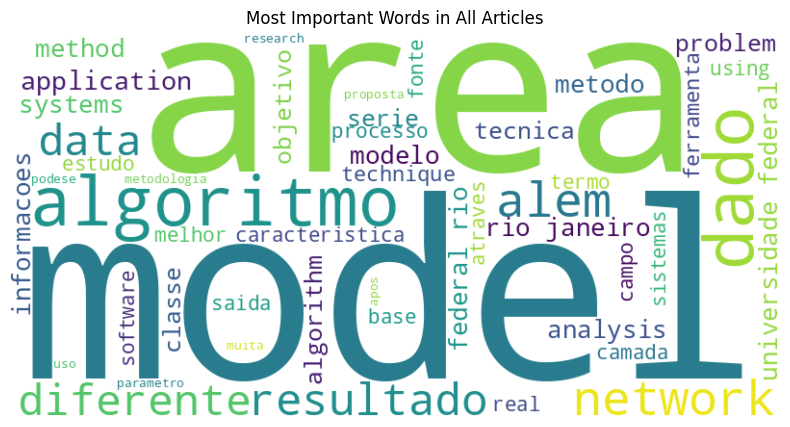

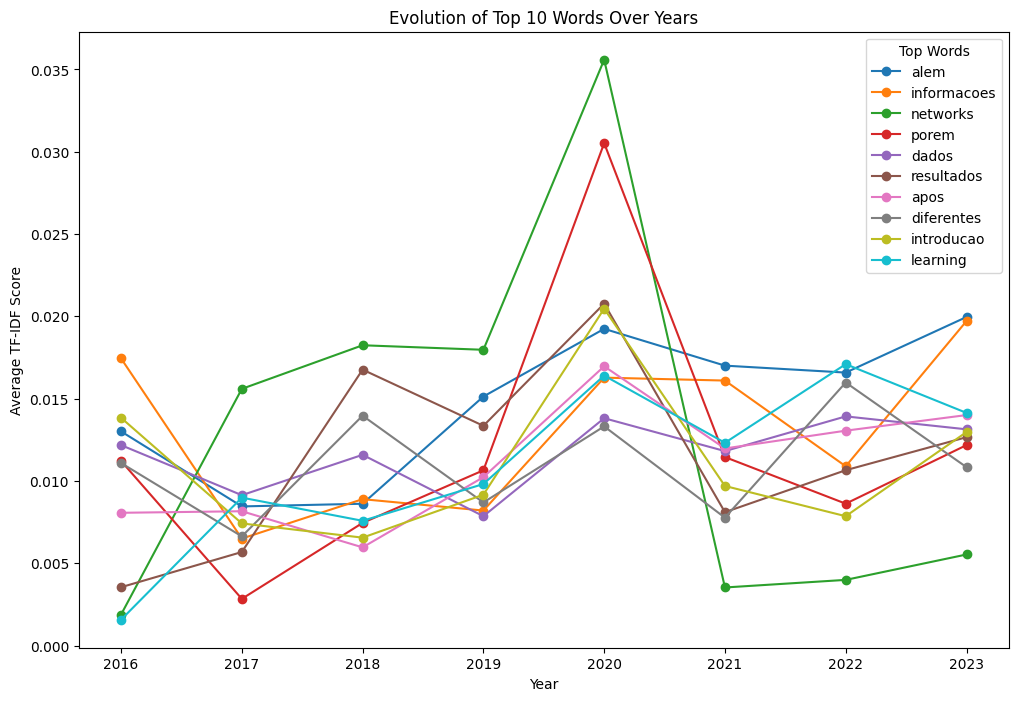

In [ ]:
running_plots(all_text, docs_df, tfidf_features, tfidf_matrix)